In [2]:
import fsl
from fsl.data.image import Image
import skimage.io as io
import numpy as np
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
import nibabel as nib

def read_img(img_f):
    img = nib.load(img_f)
    img_data = img.get_fdata()
    shape = img_data.shape
    print("img shape is :" + str(shape))
    if len(shape) == 4:
        img_data = img_data[:, :, :, 0]
    
    return img_data

def show_3D_slice(img_data, slices_index=[0,0,0]):
    slice_0 = img_data[slices_index[0], :, :]
    slice_1 = img_data[:, slices_index[1], :]
    slice_2 = img_data[:, :, slices_index[2]]
    slices = [slice_0, slice_1, slice_2]
    fig, axes = plt.subplots(1, len(slices),figsize=((20,20)))
    
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="gray", origin="lower")    

# Preparation
## Get files
Get T1, dwi, fmap image

In [ ]:
#!bin/sh

ses='ses-1/brain'

# get T1 image that corrected by fsl_anat
for sub in ../anat/sub*; do
    sub_id=${sub:8:7}
    mkdir $sub_id 
    echo $sub_id
    cp $sub/T1_biascorr.nii.gz ${sub_id}/T1_biascorr.nii.gz
    cp $sub/T1_biascorr_brain.nii.gz ${sub_id}/T1_biascorr_brain.nii.gz
    cp $sub/T1_biascorr_brain_mask.nii.gz ${sub_id}/T1_biascorr_brain_mask.nii.gz
done

# get dwi data and corresponding fmap
for sub in ../sub*; do
    sub_id=${sub:3}
    echo $sub_id
    mkdir ${sub_id}/dwi
    cp $sub/${ses}/dwi/* ${sub_id}/dwi/
    cp $sub/${ses}/fmap/*dti* ./${sub_id}
done


## Prepare fmap
fsl_prepare_fieldmap bet

In [ ]:

#!bin/sh
# prepare fmap
for dir in sub-*; do
    sub=${dir:0:7} 
    cd $dir
    rm *.json
    fname=${sub}_ses-1_magnitude2_dti.nii.gz

    bet ${sub}_ses-1_magnitude2_dti.nii.gz ${sub}_magnitude_brain -f 0.4
    fsl_prepare_fieldmap SIEMENS ${sub}_ses-1_phase2_dti.nii.gz  ${sub}_magnitude_brain ${sub}_fmap_rads 2.46

    fi
    cd ..
done

## Eddy current correction
According to a suggestion from fsl mail list, run eddy current correction before epi_reg     
https://www.jiscmail.ac.uk/cgi-bin/wa-jisc.exe?A2=ind1601&L=FSL&P=R75512

In [4]:
!fslinfo sub-c01/dwi/sub-c01_ses-1_dti.nii.gz

data_type	INT16
dim1		112
dim2		112
dim3		75
dim4		31
datatype	4
pixdim1		2.000000
pixdim2		2.000000
pixdim3		2.000000
pixdim4		11.100000
cal_max		0.000000
cal_min		0.000000
file_type	NIFTI-1+


In [ ]:
#!bin/sh
# using eddy_openmp to correct eddy current distortion
for sub in sub-*; do
    cd $sub
    
    # creat a mask
    fslmaths *b0* -Tmean b0_mean
    bet b0_mean b0_mean_brain -m -f 0.2
    
    # run eddy
    eddy_openmp   \
    --imain=./dwi/${sub}_ses-1_dti.nii.gz \
    --mask=b0_mean_brain_mask.nii.gz \
    --index=../eddy/index.txt \
    --acqp=../eddy/acqparams.txt \
    --bvecs=./dwi/${sub}_ses-1_dti.bvec \
    --bvals=./dwi/${sub}_ses-1_dti.bval \
    --out=../eddy/${sub}_dti_eddy_corr \
    cd ..
done

### Eddy QC

In [ ]:

#!bin/sh
# stored in TBSS/eddy
for f in *eddy_corr.nii.gz; do
    sub_id=${f:0:7}
    eddy_quad ${sub_id}_dti_eddy_corr -idx index.txt -par acqparams.txt -m ../${sub_id}/b0_mean_brain_mask.nii.gz -b ../${sub_id}/dwi/${sub_id}_ses-2_dti.bval
done

eddy_squad quad_list.txt


## Registration and EPI distortion correction


In [ ]:
#!bin/sh
# using fieldmaps to perform registration and EPI distortion-correction simultaneously.
for sub in sub-c0*; do
    cd $sub
    fname = ${sub}_ses-1_magnitude2_dti.nii.gz
    epi_reg \
    --epi=../eddy/eddy_result/${sub}_dti_eddy_corr.nii.gz \
    --t1=T1_biascorr.nii.gz \
    --t1brain=T1_biascorr_brain.nii.gz \
    --fmap=${sub}_fmap_rads.nii.gz \
    --fmapmag=${sub}_ses-1_magnitude2_dti.nii.gz \
    --fmapmagbrain=${sub}_magnitude_brain.nii.gz \
    --echospacing=0.000345 \
    --pedir=y \
    --out=${sub}_dtireg & 
    cd ..
done


# Modeling
## Run DTIFIT

In [ ]:

#!bin/sh
for sub in sub*; do
    cd $sub
    dtifit \
    --data=../eddy/${sub}_dti_eddy_corr.nii.gz \
    --mask=b0_mean_brain_mask.nii.gz \
    --bvecs=dwi/${sub}_ses-1_dti.bvec \
    --bvals=dwi/${sub}_ses-1_dti.bval \
    --out=${sub}_dtifit &
    cd ..
done


## Run TBSS

In [ ]:

#!bin/sh
# collect FA image
mkdir tbss
for sub in sub*; do
    cp $sub/${sub}_dtifit_FA.nii.gz tbss/${sub}_dtifit_FA.nii.gz
done 

# Run TBSS
cd tbss
tbss_1_preproc *.nii.gz
tbss_2_reg -T
tbss_3_postreg -S
fsleyes -std1mm stats/mean_FA -cm red-yellow -dr 0.2 0.6 &
tbss_4_prestats 0.3


##  Run Randomise

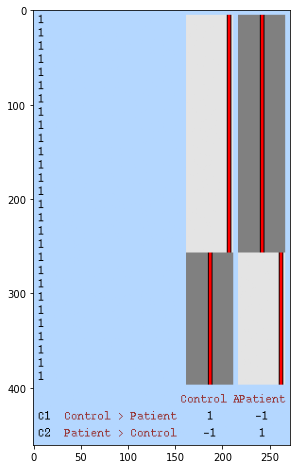

In [5]:
plt.figure(figsize=(6, 8))
im = plt.imread('./tbss/stats/design.png')
plt.imshow(im)

In [ ]:

randomise -i all_FA_skeletonised -o tbss \
  -m mean_FA_skeleton_mask -d design.mat -t design.con --T2


# Result
## FA image inspection

img shape is :(112, 112, 75)


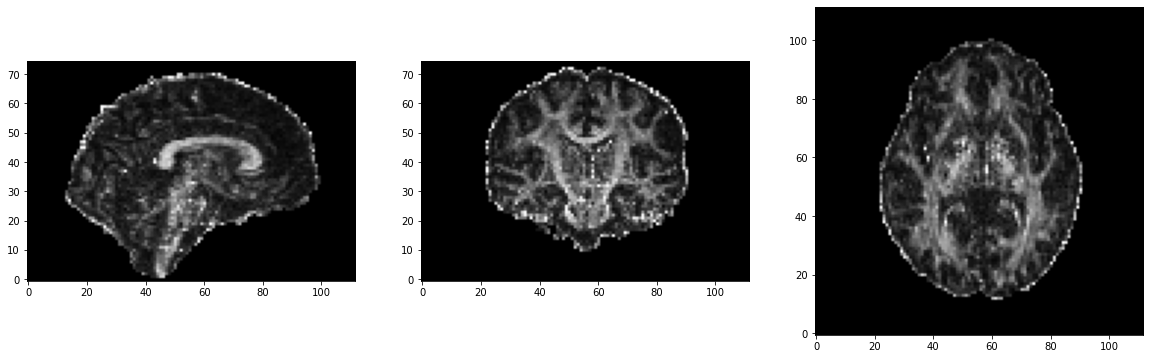

In [6]:
# FA image
epi_img = read_img('sub-c01/sub-c01_dtifit_FA.nii.gz')
show_3D_slice(epi_img, [55,55,35])

## TFCE Corrected result

In [7]:
! fsleyes -std tbss/stats/mean_FA_skeleton -cm green  \
tbss/stats/tbss_tfce_corrp_tstat1 -cm red-yellow -dr 0.949 1

In [8]:
# show fattened result
#!tbss_fill tbss_tfce_corrp_tstat1 0.95 mean_FA tbss_tfce_corrp_tstat1_filled

# Comparasion


In [ ]:
#!bin/sh
mkdir fa_values
for mask in masks/*.nii.gz; do
fslmeants -i all_FA_skeletonised -m ${mask} -o fa_values/${mask:6}_result.txt
done


In [10]:
robjects.r(
'''
perm_ind_t <- function(group1_name,group2_name,stop_num, nreps=5000, seed=1086){
test_name <- substr(group1_name,4,as.numeric(stop_num))
g1 <- as.vector(read.csv(paste('./cache/',group1_name, sep=""))[,1])
g2 <- as.vector(read.csv(paste('./cache/',group2_name, sep=""))[,1])
n1 <- length(g1)
n2 <- length(g2)
N <- n1 + n2

meanNW <- mean(g1) 
meanW <- mean(g2) 
diffObt <- (meanW - meanNW)

ttest <- t.test(g2, g1)
tObt <-  ttest$statistic

Combined <- c(g1, g2)     # Combining the samples
meanDiff <- numeric(nreps)   #Setting up arrays to hold the results
t <- numeric(nreps)
set.seed(1086)        
    
for ( i in 1:nreps) {
      data <- sample(Combined, N,  replace = FALSE)
      grp1 <- data[1:n1]
      grp2 <- na.omit(data[n1+1: N])
      meanDiff[i] <- mean(grp1) - mean(grp2)
      test <- t.test(grp1, grp2)
      t[i] <- test$statistic
      }


absMeanDiff <- abs(meanDiff)
absDiffObt = abs(diffObt)
abst <- abs(t)
abstObt <- abs(tObt)
p <- length(abs(absMeanDiff[absMeanDiff >= absDiffObt]))/nreps

return(p)  
}

''')

# A test on a correlation coefficient.
robjects.r(
'''
perm_corr <- function(group1_name, group2_name, stop_num, nreps=5000, seed=1086){
test_name <- substr(group1_name,5,as.numeric(stop_num))
group1 <- as.vector(read.csv(paste('./cache/',group1_name, sep=""))[,1])
group2 <- as.vector(read.csv(paste('./cache/',group2_name, sep=""))[,1])
r.obt <- cor(group1, group2)
r.random <- numeric(nreps)
for (i in 1:nreps) {
Y <- group1
X <- sample(group2, length(group2), replace = FALSE)
r.random[i] <- cor(X,Y)
   }
prob <- length(r.random[r.random >= r.obt])/nreps
cat("Probability randomized r >= r.obt",prob)
hist(r.random, breaks = 50, main =  expression(paste("Distribution around ",rho, "= 0")), xlab = "r from randomized samples")
r.obt <- round(r.obt, digits = 4)
legend(.40, 200, r.obt, bty = "n")
arrows(.5,150,.53, 10)

return(prob) 
}
''')


R object with classes: ('function',) mapped to:

In [14]:
# ...
pd.set_option('max_columns',1000)
pd.set_option('max_row',300)
tbss_data.groupby('timepoint').mean().T

timepoint,0,1,2
corticospinal_l,0.123134,0.119792,0.122874
external_capsule_l,0.142659,0.136539,0.139540
retrolenticular_internal_capsule_l,0.217580,0.207104,0.212609
retrolenticular_internal_capsule_r,0.209498,0.198639,0.203099
sma_r,0.142115,0.135653,0.129080
slf_l,0.067000,0.064708,0.064450
slf_r,0.139188,0.132219,0.130699
slf_temporal_l,0.091304,0.087894,0.090665
slf_temporal_r,0.101027,0.096249,0.098501
corticospinal_r,0.124888,0.120790,0.117597


In [ ]:
%store -r Scale_Filtered
%who

In [28]:
rows = len(patient_tbss.columns)
data_df = pd.DataFrame(np.zeros(rows *2).reshape(rows, 2), index=patient_tbss.columns, columns = [['Patient', 'Control'],
                                                                                                    ['Mean ± SD', 'Mean ± SD']])
for df_index, df in enumerate([patient_tbss, control_tbss]):
    col_index = 'Patient' if df_index==0 else 'Control'
    for region in control_tbss.columns:
        string = "{} ± {}".format(round(df.describe().loc['mean',region]*100,2), round(df.describe().loc['std', region]*100,2))
        data_df.loc[region, col_index] = string
data_df

,Patient,Control
,Mean ± SD,Mean ± SD
corticospinal_l,11.98 ± 0.51,12.31 ± 0.52
external_capsule_l,13.65 ± 0.77,14.27 ± 0.73
retrolenticular_internal_capsule_l,20.71 ± 1.21,21.76 ± 1.23
retrolenticular_internal_capsule_r,19.86 ± 1.51,20.95 ± 1.2
sma_r,13.57 ± 0.73,14.21 ± 0.76
slf_l,6.47 ± 0.39,6.7 ± 0.44
slf_r,13.22 ± 1.01,13.92 ± 1.18
slf_temporal_l,8.79 ± 0.56,9.13 ± 0.57
slf_temporal_r,9.62 ± 0.59,10.1 ± 0.7


In [1]:
!fsleyes -std ../TBSS_pt12/tbss/stats/mean_FA_skeleton -cm green  \
../TBSS_pt12/tbss/stats/tbss_tfce_corrp_tstat1 -cm red-yellow -dr 0.949 1